# Abstract: Topic Modeling
#### In this notebook I am implemeting LDA to extract topics:
- Goal of this notebook is to extract topics
- Decide optimal number of topics
- Evaluate topic model using techniques like:
    - Perplexity
    - Topic coherence

# LDA ( Latent Dirichlet Allocation):
<!-- + Jensen-Shannon distance -->
> LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.<br />
> Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.<br />
> LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.<br />
> It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

#### LDA has many uses:
- Understanding the different varieties topics in a corpus
- Getting a better insight into the type of documents in a corpus (whether they are about news, wikipedia articles, business documents)
- Quantifying the most used / most important words in a corpus
- and even document similarity and recommendation (here is we focus all our attention)

# Importing Libraries:

In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import multiprocessing

from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from gensim.models.coherencemodel import CoherenceModel

sns.set_style("darkgrid")

# setting colwidth to 200; help in the visual analysis of sentences 
pd.set_option("display.max_colwidth", 200)
%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

C:\Users\kaila\Anaconda3\envs\NLP_GPU_TF15\lib\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [2]:
df_text = pd.read_csv('cleaned_data.csv', usecols=['lemmatized_description'], converters={'lemmatized_description': eval})
df_text.head(3)

,lemmatized_description
0,"[dubai, group, lead, al, qaeda, ally, abu, musab, al, zarqawi, say, behead, two, iraqi, soldier, broad, daylight, mosul, statement, find, islamist, web, site, friday, say]"
1,"[santa, monica, calif, star, video, game, industry, come, force, tuesday, night, honor, peer, creative, excellence, take, page, hollywood, playbook, red, carpet, glitter, gem, live, nationwide, br..."
2,"[ap, week, rally, marche, nearly, arrest, leave, anti, bush, protester, drain, city, refute, allegation, demonstrator, hold, long, police, custody]"


### Droping short length documents: 
LDA does not work well with very short documents, because the model infers parameters from observations and if there are not enough observations (words) in a document, the model performs poorly.
>- Unlike the word2vec algorithm, which performs extremely well with full structured sentences, 
>- LDA is a bag of words model, meaning word order in a document doesnt count. 
>- This also means that stopwords and rare words should be excluded, so that the model doesnt overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.

In [ ]:
df_text = df_text.loc[(df_text['lemmatized_description']).str.len()>7]
df_text.reset_index()

## LDA Model:
>- This function trains the lda model
>- We setup parameters like number of topics, the chunksize to use in Hoffman method
>- We also do 200 passes of the data, so we want the distributions to stabilize and learn more complex relationships within documents

### Training steps:
- Split the corpus into training and testing
- Here we will split the corpus into training and testing sets.

- The training set will be used to train the LDA model on, while the testing set will be used to retrieve similar articles later in our recommendation algorithm.

- The dataframe is already shuffled from the begining, so no need to do it again.

In [3]:
# create a mask of binary values
msk = np.random.rand(len(df_text)) < 0.99
msk

array([ True,  True,  True, ..., False,  True,  True])

In [4]:
train_df = df_text[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df_text[~msk]
test_df.reset_index(drop=True,inplace=True)

In [5]:
print(len(df_text),len(train_df),len(test_df))

9993 9890 103


In [6]:
print(f'CPU cores:{multiprocessing.cpu_count()}')

CPU cores:12


### Creating Training Corpus:

In [7]:
dictionary = corpora.Dictionary(train_df['lemmatized_description'])
corpus = [dictionary.doc2bow(doc) for doc in train_df['lemmatized_description']]

In [8]:
def train_lda(num_topics):   
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, per_word_topics= True,
                              workers=12, alpha=1e-2, eta=0.5e-2, decay=0.5, 
                              chunksize=3000, passes=200, iterations=100, eval_every=50 )
    
    t2 = time.time()
    
    print(f"Time to train LDA model on {len(df_text)} articles: {round((t2-t1)/60, 2)} min")
    return dictionary,corpus,lda

### Hyperparameters:
1. `alpha` : low alpha means each document is only represented by a small number of topics, and vice versa
2. `eta`: low eta means each topic is only represented by a small number of words, and vice versa
3. `per_word_topics` : setting this to True allows for extraction of the most likely topics given a word. The training process is set in such a way that every word will be assigned to a topic. Otherwise, words that are not indicative are going to be omitted. phi_value is another parameter that steers this process - it is a threshold for a word treated as indicative or not.
4. `workers`: Parellel process nodes
5. `chunksize`: number of documents to consider at once
6. `passes`: how many times the algorithm is supposed to pass over the whole corpus

In [9]:
dictionary,corpus,lda = train_lda(100)

Time to train LDA model on 9993 articles: 9.04 min


### Let's inspect some topics!
- Word would be shortened (stemed) since we have done lemmatization

In [10]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=5, num_words=20)

[(74,
  '0.023*"warning" + 0.013*"sbc" + 0.013*"first" + 0.010*"new" + 0.010*"one" + 0.009*"renew" + 0.009*"recover" + 0.008*"security" + 0.008*"back" + 0.007*"year" + 0.007*"virus" + 0.007*"firm" + 0.006*"flu" + 0.006*"two" + 0.006*"weigh" + 0.006*"early" + 0.006*"citigroup" + 0.005*"resolve" + 0.005*"turn" + 0.005*"office"'),
 (79,
  '0.032*"focus" + 0.030*"number" + 0.020*"cell" + 0.016*"hewlett" + 0.016*"packard" + 0.013*"year" + 0.013*"main" + 0.011*"continue" + 0.009*"laptop" + 0.008*"begin" + 0.008*"use" + 0.007*"signal" + 0.007*"technology" + 0.007*"past" + 0.007*"com" + 0.007*"november" + 0.007*"software" + 0.007*"priority" + 0.007*"new" + 0.006*"partnership"'),
 (2,
  '0.012*"say" + 0.011*"toy" + 0.007*"yesterday" + 0.006*"new" + 0.006*"r" + 0.006*"one" + 0.006*"confirm" + 0.006*"day" + 0.006*"company" + 0.006*"pursuit" + 0.006*"conduct" + 0.006*"record" + 0.006*"aug" + 0.005*"body" + 0.005*"death" + 0.005*"poison" + 0.005*"amsterdam" + 0.005*"girl" + 0.005*"we" + 0.005*"larg

### We can inspect individual topics:
Below are word-probability pair for for the most relevant words generated by specific topic.

In [11]:
lda.show_topic(topicid=5, topn=20)

[('game', 0.03624221),
 ('series', 0.035290804),
 ('new', 0.030051844),
 ('boston', 0.02667157),
 ('red', 0.023702316),
 ('york', 0.02281924),
 ('los', 0.022664575),
 ('angele', 0.022263382),
 ('league', 0.019576037),
 ('yankee', 0.019299857),
 ('sox', 0.019067146),
 ('run', 0.017450055),
 ('night', 0.015349209),
 ('first', 0.014766132),
 ('two', 0.013016081),
 ('hit', 0.012752642),
 ('st', 0.012702288),
 ('three', 0.012327048),
 ('win', 0.011504047),
 ('championship', 0.011138968)]

#### Above topic is about *`Sport/Games`*

In [263]:
lda.show_topic(topicid=12, topn=20)

[('say', 0.01642621),
 ('palestinian', 0.015648587),
 ('israeli', 0.009993329),
 ('official', 0.009403791),
 ('people', 0.008840172),
 ('arafat', 0.008271918),
 ('kill', 0.007571816),
 ('gaza', 0.0075588543),
 ('west', 0.00742142),
 ('leader', 0.0072401026),
 ('ap', 0.0071881833),
 ('hurricane', 0.006960359),
 ('yasser', 0.0068754028),
 ('monday', 0.006856095),
 ('coast', 0.0067676497),
 ('south', 0.006543538),
 ('death', 0.0058850525),
 ('leave', 0.0057785227),
 ('least', 0.005474677),
 ('thursday', 0.0048365532)]

#### Above topic is about *`War/Crime`*

In [268]:
lda.show_topic(topicid=4, topn=20)

[('company', 0.017192636),
 ('software', 0.014001847),
 ('new', 0.013100878),
 ('microsoft', 0.01281454),
 ('system', 0.011893391),
 ('service', 0.011236404),
 ('say', 0.010885696),
 ('inc', 0.010707314),
 ('search', 0.010315906),
 ('corp', 0.009232124),
 ('computer', 0.008188289),
 ('business', 0.007745381),
 ('security', 0.0071209045),
 ('technology', 0.0067688306),
 ('web', 0.0066707595),
 ('internet', 0.0063829715),
 ('ibm', 0.0062359865),
 ('million', 0.006210152),
 ('product', 0.0061969757),
 ('google', 0.006180304)]

#### Above topic is about *`Tech`*

In [269]:
lda.show_topic(topicid=8, topn=20)

[('stock', 0.01668219),
 ('price', 0.016644198),
 ('oil', 0.014859514),
 ('new', 0.013441818),
 ('reuter', 0.012183292),
 ('say', 0.0120529095),
 ('percent', 0.0120086875),
 ('investor', 0.011222542),
 ('fullquote', 0.010995172),
 ('quarter', 0.010359705),
 ('unitedstate', 0.010222423),
 ('report', 0.010180369),
 ('high', 0.009779989),
 ('rise', 0.00973109),
 ('sale', 0.009636175),
 ('york', 0.009593787),
 ('year', 0.009093297),
 ('inc', 0.009077895),
 ('n', 0.0089363),
 ('profit', 0.0079619475)]

#### Above topic is about *`Finance`*

## Testing with train dataset:
#### Now, not only can we see the word contribution for each topic, but we can also visualise the topic contribution for each article.


In [196]:
random_article_index = np.random.randint(len(train_df['lemmatized_description']))
bow = dictionary.doc2bow(train_df['lemmatized_description'][random_article_index])
print(train_df['lemmatized_description'][random_article_index])
print(random_article_index)

['coach', 'herman', 'edward', 'concerned', 'player', 'dismal', 'show', 'one', 'n', 'f', 'l', 'elite', 'portend', 'jet', 'hope', 'make', 'playoff']
1791


In [197]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

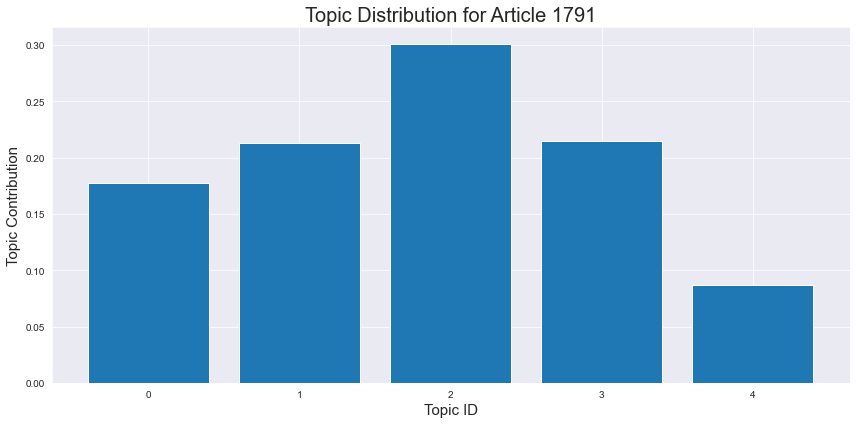

In [198]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
# ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

### The top 5 contributing topics and their words

In [199]:
for i in doc_distribution.argsort()[-10:]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

4 [('company', 0.017192636), ('software', 0.014001847), ('new', 0.013100878), ('microsoft', 0.01281454), ('system', 0.011893391), ('service', 0.011236404), ('say', 0.010885696), ('inc', 0.010707314), ('search', 0.010315906), ('corp', 0.009232124)] 

0 [('san', 0.016598182), ('los', 0.016075853), ('angele', 0.015491282), ('francisco', 0.007713916), ('co', 0.006629986), ('motor', 0.0063480465), ('intel', 0.0052530766), ('disney', 0.0052026454), ('giant', 0.0050619747), ('dodger', 0.004530154)] 

1 [('say', 0.017623145), ('minister', 0.017087806), ('state', 0.013551522), ('united', 0.013106325), ('prime', 0.011155107), ('government', 0.009907291), ('nuclear', 0.009433383), ('nation', 0.008901264), ('we', 0.0070207133), ('p', 0.006833597)] 

3 [('president', 0.025853321), ('bush', 0.015775865), ('year', 0.01253673), ('new', 0.0089359), ('john', 0.00855155), ('ap', 0.007438619), ('say', 0.006867067), ('minister', 0.0063512977), ('kerry', 0.0061565014), ('election', 0.005830669)] 

2 [('quot

### From above we can interpret that:
The topics are about:
- online Search
- Law/court
- Space
- Award function
- Food industry

In [19]:
vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=corpus, dictionary= dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Selecting a topic model & topics within it:
> In the example code given above, the number of topics was set to 100. But how did I chose this magic number 100? The hardest and the most elusive part of topic modeling is the selection of the number of topics.

Two important techniques used to evaluate topic models
1. `Perplexity`
2. `Topic coherence`

### 1. Perplexity
1. `Perplexity` (might not be such a great measure):
    >- Given a trained model, perplexity tries to measure how this model is surprised when it is given a new dataset. This is measured as the normalized log-likelihood of the held out test set. The lower the perplexity, the better the model.<br />
    >- Calculates the log-likelihood; the probability of observing some unseen data given a model learned earlier. This checks whether the model captures the distribution of the held out set. If it doesn’t then the perplexity is very high suggesting that model is bad. However, studies have shown the following:

#### While working with test data:
- *In obtaining the BOW representation for this unseen article, gensim cleverly only considers words in the existing dictionary we used to train the model*
- *So if there are new words in this article, they will `not be considered` when infering the topic distribution.*
- *This is good in that no errors arise for unseen words,*
- *But bad in that some words may be cut out, and therefore we could miss out on an accurate topic distribution for this article.*

In [288]:
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

24


In [289]:
new_bow = dictionary.doc2bow(test_df['lemmatized_description'][random_article_index])

In [290]:
print(test_df['lemmatized_description'][random_article_index])


['quot', 'fact', 'non', 'we', 'vendor', 'like', 'nec', 'fast', 'computer', 'see', 'big', 'challenge', 'we', 'computer', 'industry', 'quot', 'say', 'horst', 'simon', 'director', 'supercomputing', 'centre', 'lawrence', 'berkeley', 'lab', 'california']


In [291]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
new_doc_distribution

array([0.30003938, 0.24135229, 0.17912436, 0.14917009, 0.12593198],
      dtype=float32)

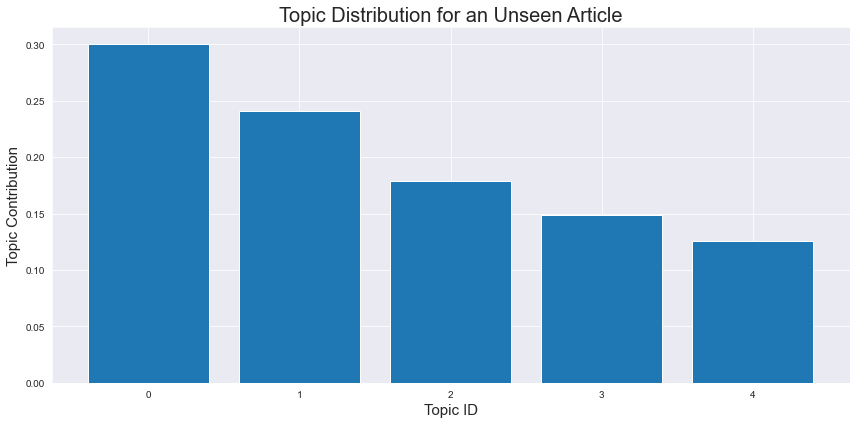

In [292]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
# ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [143]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

0 [('san', 0.016598182), ('los', 0.016075853), ('angele', 0.015491282), ('francisco', 0.007713916), ('co', 0.006629986), ('motor', 0.0063480465), ('intel', 0.0052530766), ('disney', 0.0052026454), ('giant', 0.0050619747), ('dodger', 0.004530154)] 

2 [('quot', 0.022863865), ('say', 0.015786635), ('drug', 0.010330836), ('year', 0.009199708), ('new', 0.008615711), ('yesterday', 0.00615377), ('one', 0.006058674), ('world', 0.005053046), ('may', 0.0048578773), ('would', 0.0043468405)] 

3 [('president', 0.025853321), ('bush', 0.015775865), ('year', 0.01253673), ('new', 0.0089359), ('john', 0.00855155), ('ap', 0.007438619), ('say', 0.006867067), ('minister', 0.0063512977), ('kerry', 0.0061565014), ('election', 0.005830669)] 

1 [('say', 0.017623145), ('minister', 0.017087806), ('state', 0.013551522), ('united', 0.013106325), ('prime', 0.011155107), ('government', 0.009907291), ('nuclear', 0.009433383), ('nation', 0.008901264), ('we', 0.0070207133), ('p', 0.006833597)] 

4 [('company', 0.017

### 2. Topic coherence:
2. `Topic coherence`:
    >- Here we quantify the coherence of a topic by measuring the degree of semantic similarity between its high scoring words.T(hese measurements help distinguish between topics that are human interpretable and those that are artifacts of statistical inference.)
    >- To compute topic coherence of a topic model, we perform the following steps:
        1. Select the top n frequently occurring words in each topic
        2. Compute pairwise scores for each of the words selected above and aggregate all the pairwise scores to calculate the coherence score for a particular topic.
        3. Take a mean of the coherence score per topic for all topics in the model to arrive at a score for the topic model.
        

In [27]:
# Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3, 50)
for num_topics in tqdm(num_topics_list):

#     lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
#              passes=20, chunksize=4000,random_state=43)
    dictionary,corpus,lda = train_lda(num_topics)
    cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    
#     cm_cv = CoherenceModel(model=lda, corpus=corpus, texts=skillList, dictionary=dictionary, coherence='c_v')
#     coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

Time to train LDA model on 9993 articles: 4.26 min
Time to train LDA model on 9993 articles: 4.79 min
Time to train LDA model on 9993 articles: 6.15 min
Time to train LDA model on 9993 articles: 5.3 min
Time to train LDA model on 9993 articles: 5.46 min
Time to train LDA model on 9993 articles: 5.46 min
Time to train LDA model on 9993 articles: 5.6 min
Time to train LDA model on 9993 articles: 5.91 min
Time to train LDA model on 9993 articles: 6.24 min
Time to train LDA model on 9993 articles: 6.03 min
Time to train LDA model on 9993 articles: 5.73 min
Time to train LDA model on 9993 articles: 6.01 min
Time to train LDA model on 9993 articles: 5.87 min
Time to train LDA model on 9993 articles: 5.67 min
Time to train LDA model on 9993 articles: 5.59 min
Time to train LDA model on 9993 articles: 6.27 min
Time to train LDA model on 9993 articles: 5.97 min
Time to train LDA model on 9993 articles: 6.05 min
Time to train LDA model on 9993 articles: 5.75 min
Time to train LDA model on 9993 a

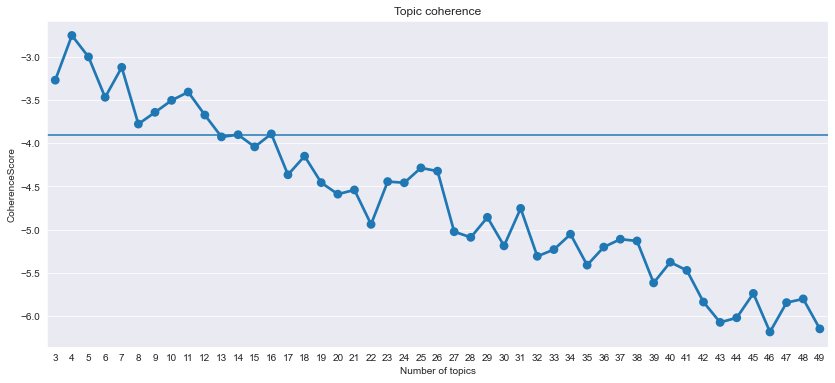

In [28]:
plotData = pd.DataFrame({'Number of topics':num_topics_list, 'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(14,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

#### How do we decide on a threshold for our coherence score?
- The above plot shows that coherence score increases with the number of topics, with a decline between 15 to 22.
- Now, choosing the number of topics still depends on our requirement because topic around 11 have good coherence scores but may have repeated keywords in the topic.
- Topic coherence gives you a good picture so that you can take better decision.



## Finale Model:
Based on above data lets make finale model with 16 topics

In [29]:
Lda = models.LdaMulticore
lda = Lda(corpus=corpus, num_topics=16, id2word=dictionary, per_word_topics= True,
                              workers=12, alpha=1e-2, eta=0.5e-2, decay=0.5, 
                              chunksize=3000, passes=200, iterations=1000, eval_every=50)

In [30]:
lda.save('lda')
dictionary.save('dictionary')
corpora.MmCorpus.serialize('corpus.mm', corpus)

### Topic Evaluation:

In [50]:
a = lda.show_topics(num_topics=16, formatted=False, num_words=20)
b = lda.top_topics(corpus, dictionary=dictionary, topn=20) # This orders the topics in the decreasing order of coherence score


In [51]:
topic2skillb = {}
topic2csb = {}
topic2skilla = {}
topic2csa = {}
num_topics =lda.num_topics
cnt =1

for ws in b:
    wset = set(w[1] for w in ws[0])
    topic2skillb[cnt] = wset
    topic2csb[cnt] = ws[1]
    cnt +=1

for ws in a:
    wset = set(w[0]for w in ws[1])
    topic2skilla[ws[0]+1] = wset
    
for i in range(1,num_topics+1):
    for j in range(1,num_topics+1):  
        if topic2skilla[i].intersection(topic2skillb[j])==topic2skilla[i]:
            topic2csa[i] = topic2csb[j]


In [52]:
finalData = pd.DataFrame([],columns=['Topic','words'])
finalData['Topic']=topic2skilla.keys()
finalData['Topic'] = finalData['Topic'].apply(lambda x: 'Topic'+str(x))
finalData['words']=topic2skilla.values()
finalData['CoherenceScore'] = topic2csa.values()
finalData.sort_values(by='CoherenceScore',ascending=False, inplace=True)
finalData.to_csv('CoherenceScore.csv')
finalData

,Topic,words,CoherenceScore
8,Topic9,"{investor, fullquote, high, york, rise, n, unitedstate, year, oil, price, percent, quarter, inc, say, new, stock, profit, reuter, report, sale}",-2.098644
6,Topic7,"{victory, first, two, point, run, team, play, lead, season, game, night, second, score, ap, three, sunday, new, yard, last, win}",-2.628456
5,Topic6,"{least, official, iraqi, force, two, police, kill, people, bomb, unitedstate, troop, al, militant, government, we, say, attack, iraq, baghdad, group}",-2.855229
15,Topic16,"{company, first, technology, computer, service, mail, store, software, music, quot, use, say, new, apple, video, announce, internet, inc, microsoft, online}",-3.185742
4,Topic5,"{product, google, company, ibm, technology, business, search, computer, corp, security, million, system, web, software, say, new, service, internet, inc, microsoft}",-3.500844
9,Topic10,"{grand, series, first, yankee, fan, year, sox, quot, boston, time, night, red, game, last, new, season, race, york, world, team}",-3.665817
11,Topic12,"{goal, football, match, world, london, win, saturday, england, club, league, united, last, champion, manager, ap, international, one, team, test, cup}",-3.802201
14,Topic15,"{rule, first, two, election, yesterday, week, year, day, state, european, vote, president, tax, ap, we, say, last, court, talk, presidential}",-3.807934
13,Topic14,"{company, airline, group, cut, wireless, communication, million, year, european, executive, billion, union, say, plan, announce, new, inc, chief, tuesday, phone}",-3.860511
3,Topic4,"{election, prime, george, president, year, kerry, state, ariel, bush, minister, sharon, national, campaign, ap, next, john, new, say, plan, presidential}",-4.297581


### Visualizing:


In [61]:
num_topics =20
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')
vis

# pyLDAvis.enable_notebook()
# pyLDAvis.display(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015466 -0.066052       1        1   3.457386
1      0.027519  0.171624       2        1   7.080494
2      0.076244  0.017967       3        1   5.625489
3     -0.040306  0.111496       4        1   5.324687
4      0.246037 -0.118272       5        1   8.806335
5      0.015472  0.217569       6        1   8.268087
6     -0.224644 -0.123353       7        1   7.147090
7     -0.205266 -0.079899       8        1   4.559304
8      0.137882 -0.054042       9        1  13.323947
9     -0.165645 -0.095797      10        1   5.264173
10     0.012160 -0.035216      11        1   3.838438
11    -0.168492 -0.058348      12        1   4.584084
12    -0.040941  0.212960      13        1   4.705253
13     0.170375 -0.034721      14        1   6.281013
14    -0.011502  0.071085      15        1   5.371817
15     0.155640 -0.137001      16        1   6.362404, topic_info=          Term        Freq       Total Category  logprob  loglift
343       quot  677.000000  677.000000  Default  30.0000  30.0000
650      stock  437.000000  437.000000  Default  29.0000  29.0000
364      price  436.000000  436.000000  Default  28.0000  28.0000
639    company  761.000000  761.000000  Default  27.0000  27.0000
83   president  470.000000  470.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
343       quot   67.833005  677.570746  Topic16  -5.2174   0.4533
369      first   65.927312  702.955520  Topic16  -5.2459   0.3880
667       make   54.977975  498.368264  Topic16  -5.4276   0.5504
35    industry   49.363694  170.164673  Topic16  -5.5353   1.5172
585       news   48.829653  220.800496  Topic16  -5.5462   1.2458

[1170 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3987      4  0.997220     abbas
3839     14  0.990903     abbey
5634     15  0.997995  abortion
0         6  1.003508       abu
3894      2  0.995348     abuja
...     ...       ...       ...
2194      5  0.039384   zealand
2194      7  0.216611   zealand
2194      8  0.118151   zealand
2194     12  0.177227   zealand
4944      5  1.002201      ziff

[3223 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

### Picking relevant words in each topic?

In [93]:
token_percent = vis.topic_coordinates.sort_values(by='topics').loc[:,['topics','Freq']]
token_percent

,topics,Freq
topic,,
0,1,3.457386
1,2,7.080494
2,3,5.625489
3,4,5.324687
4,5,8.806335
5,6,8.268087
6,7,7.147090
7,8,4.559304
8,9,13.323947


In [94]:
finalData.sort_index(ascending=True)
finalData['Token_percentage'] = token_percent['Freq']
finalData.sort_values(by='Token_percentage',ascending=False, inplace=True)
finalData

,Topic,words,CoherenceScore,Token_percentage
8,Topic9,"{investor, fullquote, high, york, rise, n, unitedstate, year, oil, price, percent, quarter, inc, say, new, stock, profit, reuter, report, sale}",-2.098644,13.323947
4,Topic5,"{product, google, company, ibm, technology, business, search, computer, corp, security, million, system, web, software, say, new, service, internet, inc, microsoft}",-3.500844,8.806335
5,Topic6,"{least, official, iraqi, force, two, police, kill, people, bomb, unitedstate, troop, al, militant, government, we, say, attack, iraq, baghdad, group}",-2.855229,8.268087
6,Topic7,"{victory, first, two, point, run, team, play, lead, season, game, night, second, score, ap, three, sunday, new, yard, last, win}",-2.628456,7.147090
1,Topic2,"{nuclear, secretary, official, iran, prime, president, un, state, region, nation, minister, quot, government, united, say, we, iraq, talk, p, trade}",-4.413863,7.080494
15,Topic16,"{company, first, technology, computer, service, mail, store, software, music, quot, use, say, new, apple, video, announce, internet, inc, microsoft, online}",-3.185742,6.362404
13,Topic14,"{company, airline, group, cut, wireless, communication, million, year, european, executive, billion, union, say, plan, announce, new, inc, chief, tuesday, phone}",-3.860511,6.281013
2,Topic3,"{news, platform, back, may, world, people, yesterday, make, year, administration, long, quot, go, say, new, take, would, one, drug, plan}",-4.825494,5.625489
14,Topic15,"{rule, first, two, election, yesterday, week, year, day, state, european, vote, president, tax, ap, we, say, last, court, talk, presidential}",-3.807934,5.371817
3,Topic4,"{election, prime, george, president, year, kerry, state, ariel, bush, minister, sharon, national, campaign, ap, next, john, new, say, plan, presidential}",-4.297581,5.324687


- topic 13, 12, 8, 11, 1 have token percentage below 5% and low coherence score
- Hence they can be discarded
- For more versatile results lets discard only bottom 2

In [97]:
# 13, 12, 8, 11, 1 
finalData = finalData.drop([11, 1 ]) 
finalData

,Topic,words,CoherenceScore,Token_percentage
8,Topic9,"{investor, fullquote, high, york, rise, n, unitedstate, year, oil, price, percent, quarter, inc, say, new, stock, profit, reuter, report, sale}",-2.098644,13.323947
4,Topic5,"{product, google, company, ibm, technology, business, search, computer, corp, security, million, system, web, software, say, new, service, internet, inc, microsoft}",-3.500844,8.806335
5,Topic6,"{least, official, iraqi, force, two, police, kill, people, bomb, unitedstate, troop, al, militant, government, we, say, attack, iraq, baghdad, group}",-2.855229,8.268087
6,Topic7,"{victory, first, two, point, run, team, play, lead, season, game, night, second, score, ap, three, sunday, new, yard, last, win}",-2.628456,7.147090
15,Topic16,"{company, first, technology, computer, service, mail, store, software, music, quot, use, say, new, apple, video, announce, internet, inc, microsoft, online}",-3.185742,6.362404
13,Topic14,"{company, airline, group, cut, wireless, communication, million, year, european, executive, billion, union, say, plan, announce, new, inc, chief, tuesday, phone}",-3.860511,6.281013
2,Topic3,"{news, platform, back, may, world, people, yesterday, make, year, administration, long, quot, go, say, new, take, would, one, drug, plan}",-4.825494,5.625489
14,Topic15,"{rule, first, two, election, yesterday, week, year, day, state, european, vote, president, tax, ap, we, say, last, court, talk, presidential}",-3.807934,5.371817
3,Topic4,"{election, prime, george, president, year, kerry, state, ariel, bush, minister, sharon, national, campaign, ap, next, john, new, say, plan, presidential}",-4.297581,5.324687
9,Topic10,"{grand, series, first, yankee, fan, year, sox, quot, boston, time, night, red, game, last, new, season, race, york, world, team}",-3.665817,5.264173


In [308]:
def get_relevant_words(vis,lam=0.5,topn=20):
    a = vis.topic_info
    a['finalscore'] = a['logprob']*lam+(1-lam)*a['loglift']
    a = a.loc[:,['Category','Term','finalscore']].groupby(['Category'])\
    .apply(lambda x: x.sort_values(by='finalscore',ascending=False).head(topn))
    a = a.loc[:,'Term'].reset_index().loc[:,['Category','Term']]
    a = a[a['Category']!='Default']
    a = a.to_dict('split')['data']
    d ={}
    for k,v in a: 
        if k not in d.keys():
            d[k] =set()
            d[k].add(v)
        else:
            d[k].add(v)
    finalData = pd.DataFrame([],columns=['Topic','words with Relevance'])
    finalData['Topic']=d.keys()
    finalData['words with Relevance']=d.values()
    return finalData

In [309]:
get_relevant_words(vis,0.7).merge(finalData,how='left',on ='Topic').sort_values(by='CoherenceScore',ascending=False).iloc[:,[0,1]]

,Topic,words with Relevance
15,Topic9,"{investor, fullquote, n, high, rise, york, unitedstate, reuter, http, oil, price, quarter, www, profit, new, stock, low, percent, report, sale}"
13,Topic7,"{victory, first, two, point, run, touchdown, quarterback, th, play, lead, season, game, score, second, night, yard, sunday, three, ap, win}"
12,Topic6,"{least, official, iraqi, bomb, two, police, kill, people, force, troop, hostage, al, militant, we, attack, say, iraq, baghdad, military, group}"
7,Topic16,"{ipod, company, spam, digital, device, medium, technology, computer, mail, store, download, music, sony, use, apple, video, e, internet, microsoft, online}"
11,Topic5,"{google, oracle, company, product, ibm, peoplesoft, technology, business, search, computer, corp, window, system, web, software, service, server, new, inc, microsoft}"
1,Topic10,"{prison, series, prix, yankee, fan, sentence, sox, quot, boston, race, night, red, game, season, new, grand, last, york, pitcher, team}"
6,Topic15,"{rule, election, week, yesterday, year, day, negotiator, kabul, vote, european, tax, eu, senate, afghanistan, karzai, court, talk, hamid, presidential, voter}"
5,Topic14,"{carrier, airline, company, mobile, cut, wireless, communication, million, european, bankruptcy, executive, billion, agreement, union, say, plan, television, inc, chief, phone}"
10,Topic4,"{election, george, prime, president, year, kerry, ariel, campaign, bush, sharon, minister, democratic, candidate, ap, war, john, new, israel, presidential, w}"
14,Topic8,"{tournament, first, tennis, player, louis, open, athen, round, final, gold, roger, medal, title, game, champion, st, world, olympic, win, cup}"


## >>>Labeling The Documents based on topics:
Steps:
- Give category name to each topic
- Classify each document based on extracted topic
- Assign category name to each document
- Train Model or we can use similar model to predict category of new document
- We can use Entity linking model

## Similarity Query:
> Now that we have a topic distribution for a new unseen document, let's say we wanted to find the most similar documents in the corpus. We can do this by comparing the topic distribution of the new document to all the topic distributions of the documents in the corpus. We use the Jensen-Shannon distance metric to find the most similar documents.

#### `Jensen-Shannon distance`:
>- It tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. <br />
>- This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A. <br />
>- The smaller the Jensen-Shannon Distance, the more similar two distributions are (and in our case, the more similar any 2 documents are)

#### Preprocessing:
- we need to get all our LDA topic distributions into a dense matrix. This will enable fast and efficient computation.
- We will create a dense matrix, doc_topic_dist, of size  M×K  where  M  is the number of documents and  K  is the number of topics.

In [174]:
# doc_topic_dist = np.array([[tup[1] for tup in lst if len(tup)>1] for lst in lda[corpus]])
# doc_topic_dist = np.array([[tup[1] for tup in lst[0]] for lst in lda[corpus]])
# doc_topic_dist.shape
lda_corpus_dist = []
for lst in lda[corpus]:
    row = []
    for tup in lst[0]:
        row.append(tup[1])
    lda_corpus_dist.append(row)
    
doc_topic_dist = np.asarray(lda_corpus_dist) 
doc_topic_dist.shape

(9890,)

#### Below function:
> This function implements a Jensen-Shannon similarity between the input query (an LDA topic distribution for a document) and the entire corpus of topic distributions.<br />
It returns an array of length M where M is the number of documents in the corpus

In [255]:
# def jensen_shannon(query, matrix):
#     p = query[None,:].T # take transpose
#     q = matrix.T # transpose matrix
#     m = 0.5*(p + q)
#     return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))
from scipy.spatial import distance
def jensen_shannon(query, matrix):
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return sim

#### Let's compare the new unseen document, to the corpus, and see which articles are most similar.
> This function implements the Jensen-Shannon distance above and retruns the top k indices of the smallest jensen shannon distances

In [256]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims # the top k positional index of the smallest Jensen Shannon distances


#### We are comparing the new unseen document above to the entire corpus of ~10k documents to find which one is most similar to the new document.
- How are we doing that? 
    - We have the new documents LDA topic distribution in stored as varibale new_doc_distribution, and 
    - We have the entire corpus of documents topic distributions stored in the dense matrix doc_topic_dist. 
    - Now, we pass each row of doc_topic_dist through the Jensen-Shannon function above as the Q distribution, while
    - The P distribution remains static as new_doc_distribution. 
    - Then we get the smallest distances and their corresponding index in the array, which we can pass to the train_df dataframe to print out the most similar documents.

#### Get Most similar documents:

In [258]:
most_sim_ids = get_most_similar_documents(new_doc_distribution[2:], doc_topic_dist)

In [296]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df.iloc[0]

lemmatized_description    [dubai, group, lead, al, qaeda, ally, abu, musab, al, zarqawi, say, behead, two, iraqi, soldier, broad, daylight, mosul, statement, find, islamist, web, site, friday, say]
Name: 0, dtype: object

### Analysis:
- LDA assumes that each document will contain several topics, so that there is topic overlap within a document.
- The words in each document contribute to these topics.
- Since its unsupervised training we dont known the topics, and needn't even be specified, but the number of topics must be specified a priori.
- The number of topic is arbitrary and I decide it using Coherence score
- The model itself does not actually do any "naming" or classifying of topics. But by visually inspecting the top contributing words of a topic we can specify topic
- Some generated topics are descrete and have words with better semantic meaning

#### Downside:
- LDA does not work well with very short documents
- 90% of our data has token length between 10 - 30 which is short

## >>Future Work:
### Document Classification:
#### Steps:
1. **`Labeling`**: Labele the documents based on found clusters
2. **`Classification`**: We can try various Ml models based on our model performance, like logistic regression or Train Deep Learning RNN based model (LSTM would be good choice) document classification
3. **`Evaluation`**:
    - 3.1 **`Model-Based Evaluation`**: Here we can can used our previous model TF-IDF, Doc2Vec and LDA to validated if document classification have similar cluster by comparing with all three
    - 3.2 **`Sent2Vec/TF-IDF Similarity`**: we can compute Sent2vec similarity or TF-IDF between predicted cluster word and target word
    - 3.3 **`Entity-Pos Tag Based Evaluation`**: we can compare if entities with target sentiment and clusrers have similarities

#### Implement a `Biterm topic model` since we have short texts or `BERT`